# **1. Loading libraries and writing functions**

In [95]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series
import os
import requests  
from pprint import pprint 
from bs4 import BeautifulSoup    
from tqdm.notebook import tqdm
import time
from random import randint
import lxml
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')
from catboost import CatBoostRegressor
import ipywidgets as widgets
from ipywidgets import interact
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor,StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
import xgboost as xgb


In [2]:
# Fix versions:
!pip freeze > requirements.txt
# Fix random_seed:
RANDOM_SEED = 42

In [3]:
'''# With this function we'll get list of links with cars in cities: '''

def get_links(i):  
    for c in cities_list:#loop over the cities
        for b in brand_list:#loop over the brands
            url = f'https://auto.ru/{c}/cars/{b}/used/?output_type=list&page={i}'
            response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
            
            if response.status_code != 200:# Checking for the good answer
                raise BaseException("response code" + str(response.status_code))
          
            response.encoding = 'utf-8'
            soup = BeautifulSoup(response.text, 'lxml')#read the response
            page = soup.find_all('a',class_="Link ListingItemTitle-module__link")  
            for p in range(len(page)):#scroll over the page 
                if page[p].get('href') not in page_list:#Drop the duplicates
                    page_list.append(page[p].get('href'))#add link
    time.sleep(1.2)# waiting to not get banned 

In [4]:
'''# With this function we'll get car characteristics from its url: '''

def get_cars(url):   
    
    car = requests.get(url, headers={'User-Agent': 'Mozilla/5.0'})
    
    if car.status_code != 200:
        raise BaseException("response code" + str(car.status_code))
    
    soup = BeautifulSoup(car.content, 'lxml')#read the page
    
    #And write each characteristic to its variable,editing in the process:
    name = soup.find('h1').text 
    link = url
    year = int(soup.find('li', class_="CardInfoRow CardInfoRow_year").text.replace('год выпуска',''))
    km = int(str(soup.find('li', class_="CardInfoRow CardInfoRow_kmAge")\
             .text.replace('Пробег','').replace('км','')).replace('\xa0',''))  
    body = soup.find('li', class_="CardInfoRow CardInfoRow_bodytype").text.replace('Кузов','')
    color = soup.find('li', class_="CardInfoRow CardInfoRow_color").text.replace('Цвет','')
    engine = soup.find('li', class_="CardInfoRow CardInfoRow_engine").text.replace('Двигатель','')\
             .replace('\xa0','')
    tax = int(soup.find('li', class_="CardInfoRow CardInfoRow_transportTax").text.replace('Налог','')\
             .replace('\xa0','').split('₽')[0])
    drive = soup.find('li', class_="CardInfoRow CardInfoRow_drive").text.replace('Привод','')
    trans = soup.find('li', class_="CardInfoRow CardInfoRow_transmission").text.replace('Коробка','')
    wheel = soup.find('li', class_="CardInfoRow CardInfoRow_wheel").text.replace('Руль','')
    state = soup.find('li', class_="CardInfoRow CardInfoRow_state").text.replace('Состояние','')
    owners = soup.find('li', class_="CardInfoRow CardInfoRow_ownersCount")\
            .text.replace('Владельцы','').split('\xa0')[0]
    pts = soup.find('li', class_="CardInfoRow CardInfoRow_pts").text.replace('ПТС','')
    customs = soup.find('li', class_="CardInfoRow CardInfoRow_customs").text.replace('Таможня','')
    exchange = soup.find('li', class_="CardInfoRow CardInfoRow_exchange")
    price =  int(soup.find('span', class_="OfferPriceCaption__price")\
                     .text.replace('\xa0','').replace('₽',''))
    #Packing the chrachteristics to the list:
    car_char = [name,link,year,km,body,color,engine,tax,
                trans,drive,wheel,state,owners,pts,customs,exchange,price]
    #Write list to the file by adding:
    with open('vcars.txt', 'a') as f:
        f.write('%s\n' % car_char)
    time.sleep(randint(1,3))#waiting...

In [5]:
"""This function will show us metric score of the model"""
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

# **2. Loading Data**

In [6]:
# This is the data, that we've parsed from auto.ru:
train_1 = pd.read_csv('parsed_cars.csv')
# While we were working on project, we've found a dataset on kaggle:
train_2 = pd.read_csv('dataset_with_electro.csv',
                      low_memory=False)
# And files from competition:
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')


In [7]:
'''Let's check for the most populated cities in Russia:'''
url = 'https://ru.wikipedia.org/wiki/%D0%93%D0%BE%D1%80%D0%BE%D0%B4%D0%B0-%D0%BC%D0%B8%D0%BB%D0%BB%D0%B8%D0%BE%D0%BD%D0%B5%D1%80%D1%8B_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8'  
pd.read_html(url)[1]# Looking for cities with over 1 million citizens

,Место,Город,Населениена 1 января 2020 года (тыс.)[5],Прирост относительно переписи-2010,"Население, тыс. чел.(официальные окончательные итоги переписи 2010 года[6])"
0,1,Москва,12 678,"10,2 %",11 504
1,2,Санкт-Петербург,5 398,"10,6 %",4 880
2,3,Новосибирск,1 625,"10,2 %",1 474
3,4,Екатеринбург,1 493,"10,5 %",1 350
4,5,Казань,1 257,"9,8 %",1 144
5,6,Нижний Новгород,1 252,"-0,01 %",1 251
6,7,Челябинск,1 196,"5,8 %",1 130
7,8,Самара,1 156,"-0,77 %",1 165
8,9,Омск,1 154,-1 %,1 166
9,10,Ростов-на-Дону,1 137,"4,4 %",1 089


In [8]:
cities_list = ['moskva','sankt-peterburg','novosibirsk',
               'ekaterinburg','kazan','nizhniy_novgorod',
               'chelyabinsk','samara','omsk',
               'rostov-na-donu','ufa','krasnoyarsk',
               'voronezh','perm','volgograd'                                
               ]

In [9]:
brand_list = test['brand'].unique().tolist()# list of needed brands
brand_list


['SKODA',
 'AUDI',
 'HONDA',
 'VOLVO',
 'BMW',
 'NISSAN',
 'INFINITI',
 'MERCEDES',
 'TOYOTA',
 'LEXUS',
 'VOLKSWAGEN',
 'MITSUBISHI']

In [10]:
fuel_list = test['fuelType'].unique().tolist()# list of needed fuel
fuel_list

['бензин', 'дизель', 'гибрид', 'электро', 'газ']

# Data-extracting

### In this block we'll show only the example of data-extracting, because it takes a lot of time.

In [11]:
"Getting links:"
page_list = []
begin = 0
end = 1
with tqdm(total=end-begin) as pbar:
    for i in range(begin,end):
        while True:# repeat the loop if error 
            try:
                get_links(i)
            except BaseException:
                time.sleep(randint(5,15))
                continue
            else:
                break 
        pbar.update(1) 
pages = pd.Series(page_list)
pages

0       https://auto.ru/cars/used/sale/skoda/octavia/1...
1       https://auto.ru/cars/used/sale/skoda/kodiaq/11...
2       https://auto.ru/cars/used/sale/skoda/rapid/110...
3       https://auto.ru/cars/used/sale/skoda/superb/11...
4       https://auto.ru/cars/used/sale/skoda/yeti/1102...
                              ...                        
6550    https://auto.ru/cars/used/sale/mitsubishi/l200...
6551    https://auto.ru/cars/used/sale/mitsubishi/mont...
6552    https://auto.ru/cars/used/sale/mitsubishi/lanc...
6553    https://auto.ru/cars/used/sale/mitsubishi/paje...
6554    https://auto.ru/cars/used/sale/mitsubishi/ek_w...
Length: 6555, dtype: object

In [14]:
'''And now let's write car characteristcs to the file: '''
with tqdm(total=10) as pbar:
     for u in page_list[0:11]:
        try:
            get_cars(u)
            
        except:
            time.sleep(randint(1,14))  
            pass 
        pbar.update(1)

In [15]:
'''Finally get the DataFrame:'''
cars_from_txt = []

# open file and read it to the list
with open('vcars.txt', 'r') as filehandle:
    for line in filehandle:
        # delete last symbol
        currentPlace = line[:-1]

        # add to the list:
        cars_from_txt.append(currentPlace.split(','))
pd.DataFrame(cars_from_txt)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,['Skoda Octavia III (A7)','https://auto.ru/cars/used/sale/skoda/octavia...,2014,177000,'лифтбек','белый','1.6 л / 110л.с. / Бензин',2750,'механическая','передний','Левый','Не требует ремонта','1','Оригинал','Растаможен',None,785000]
1,['Skoda Kodiaq I','https://auto.ru/cars/used/sale/skoda/kodiaq/...,2018,81000,'внедорожник 5 дв.','белый','1.4 л / 150л.с. / Бензин',5250,'роботизированная','полный','Левый','Не требует ремонта','1','Оригинал','Растаможен',None,2080000]
2,['Skoda Rapid II','https://auto.ru/cars/used/sale/skoda/rapid/1...,2021,45,'лифтбек','белый','1.6 л / 110л.с. / Бензин',2750,'автоматическая','передний','Левый','Не требует ремонта','1','Оригинал','Растаможен',None,983000]
3,['Skoda Superb III','https://auto.ru/cars/used/sale/skoda/superb/...,2018,39583,'лифтбек','синий','1.8 л / 180л.с. / Бензин',8820,'роботизированная','передний','Левый','Не требует ремонта','1','Оригинал','Растаможен',"<li class=""CardInfoRow CardInfoRow_exchange"">...",1890000]
4,['Skoda Yeti I Рестайлинг','https://auto.ru/cars/used/sale/skoda/yeti/11...,2015,82628,'внедорожник 5 дв.','серый','1.6 л / 110л.с. / Бензин',2750,'механическая','передний','Левый','Не требует ремонта','2','Оригинал','Растаможен',"<li class=""CardInfoRow CardInfoRow_exchange"">...",839000]
5,['Skoda Octavia RS II Рестайлинг','https://auto.ru/cars/used/sale/skoda/octavia...,2010,160000,'лифтбек','жёлтый','2.0 л / 200л.с. / Бензин',10000,'роботизированная','передний','Левый','Не требует ремонта','2','Оригинал','Растаможен',"<li class=""CardInfoRow CardInfoRow_exchange"">...",595000]
6,['Skoda Yeti I Рестайлинг','https://auto.ru/cars/used/sale/skoda/yeti/11...,2014,187045,'внедорожник 5 дв.','серебристый','1.8 л / 152л.с. / Бензин',6840,'роботизированная','полный','Левый','Не требует ремонта','2','Оригинал','Растаможен',None,807000]
7,['Skoda Kodiaq I','https://auto.ru/cars/used/sale/skoda/kodiaq/...,2019,26319,'внедорожник 5 дв.','серый','1.4 л / 125л.с. / Бензин',3125,'механическая','передний','Левый','Не требует ремонта','1','Оригинал','Растаможен',"<li class=""CardInfoRow CardInfoRow_exchange"">...",1600000]
8,['Skoda Yeti I Рестайлинг','https://auto.ru/cars/used/sale/skoda/yeti/11...,2015,78000,'внедорожник 5 дв.','белый','1.8 л / 152л.с. / Бензин',6840,'роботизированная','полный','Левый','Не требует ремонта','2','Оригинал','Растаможен',"<li class=""CardInfoRow CardInfoRow_exchange"">...",890000]
9,['Skoda Octavia III (A7)','https://auto.ru/cars/used/sale/skoda/octavia...,2015,89000,'лифтбек','белый','1.4 л / 140л.с. / Бензин',4900,'роботизированная','передний','Левый','Не требует ремонта','3 или более','Оригинал','Растаможен',"<li class=""CardInfoRow CardInfoRow_exchange"">...",735000]


# **3. Working with data** 

### Test

In [16]:
#Let's look what we have in test colunmn:
print(test.info())
test.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,...,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
8676,седан,BMW,https://auto.ru/cars/used/sale/bmw/5er/1093874...,коричневый,"{""id"":""21385516"",""name"":""520d xDrive Business""...","Покупалась в салоне-новая,немецкой сборки.На г...",2.0 LTR,190 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",дизель,...,SEDAN AUTOMATIC 2.0,автоматическая,EUROPEAN,1 владелец,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
2195,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,белый,NaN,Доброго времени суток. \nАвто сел и поехал. Мн...,1.8 LTR,152 N12,"{""16-inch-wheels"":true,""ptf"":true,""adaptive-li...",бензин,...,LIFTBACK AUTOMATIC 1.8,автоматическая,EUROPEAN,3 или более,1 год и 6 месяцев,Оригинал,передний,Левый,Не требует ремонта,Растаможен
6904,внедорожник 5 дв.,VOLVO,https://auto.ru/cars/used/sale/volvo/xc60/1098...,чёрный,NaN,Автомобиль с оригинальным пробегами и не краше...,2.4 LTR,163 N12,"{""engine-proof"":true,""tinted-glass"":true,""esp""...",дизель,...,ALLROAD_5_DOORS AUTOMATIC 2.4,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,полный,Левый,Не требует ремонта,Растаможен
17615,седан,MERCEDES,https://auto.ru/cars/used/sale/mercedes/e_klas...,коричневый,NaN,Торг возле авто,2.2 LTR,170 N12,"{""asr"":true,""tinted-glass"":true,""esp"":true,""mu...",дизель,...,SEDAN AUTOMATIC 2.2,автоматическая,EUROPEAN,3 или более,NaN,Оригинал,задний,Левый,Не требует ремонта,Растаможен
10828,универсал 5 дв.,BMW,https://auto.ru/cars/used/sale/bmw/5er/1101246...,серебристый,NaN,Представляю вам уникальный автомобиль 2002г.в!...,2.9 LTR,193 N12,"{""cruise-control"":true,""asr"":true,""tinted-glas...",дизель,...,WAGON_5_DOORS AUTOMATIC 2.9,автоматическая,EUROPEAN,3 или более,3 месяца,Дубликат,задний,Левый,Не требует ремонта,Растаможен


In [17]:
# At first let's group and unify columns:
test = test[['sell_id','brand','model_name','bodyType','color',
     'engineDisplacement','enginePower','fuelType',
     'mileage','productionDate','vehicleTransmission','Владельцы',
     'ПТС','Привод','Руль','Состояние','Таможня']]
test.columns = ['sell_id','brand','model','bodyType','color','volume','power','fuel',
     'km','year','trans','owners','pts','drive','wheel','state','customs']


In [18]:
test = test.fillna(test.pts.loc[34683][0])# Fill Nan values in pts column
# Converting below columns to numeric format:
test.volume = pd.to_numeric(test.volume.apply(lambda x:x.split(' ')[0])) 
test.power = pd.to_numeric(test.power.apply(lambda x:x.split(' ')[0])) 
test.owners = pd.to_numeric(test.owners.apply(lambda x:x[0]))

In [19]:
# This is what we have now:
print(test.info())
test.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sell_id   34686 non-null  int64  
 1   brand     34686 non-null  object 
 2   model     34686 non-null  object 
 3   bodyType  34686 non-null  object 
 4   color     34686 non-null  object 
 5   volume    34631 non-null  float64
 6   power     34686 non-null  int64  
 7   fuel      34686 non-null  object 
 8   km        34686 non-null  int64  
 9   year      34686 non-null  int64  
 10  trans     34686 non-null  object 
 11  owners    34686 non-null  int64  
 12  pts       34686 non-null  object 
 13  drive     34686 non-null  object 
 14  wheel     34686 non-null  object 
 15  state     34686 non-null  object 
 16  customs   34686 non-null  object 
dtypes: float64(1), int64(5), object(11)
memory usage: 4.5+ MB
None


,sell_id,brand,model,bodyType,color,volume,power,fuel,km,year,trans,owners,pts,drive,wheel,state,customs
7687,1092877664,BMW,X5,внедорожник 5 дв.,синий,3.0,400,дизель,46000,2019,автоматическая,1,Оригинал,полный,Левый,Не требует ремонта,Растаможен
31719,1101350571,MERCEDES,S_KLASSE,седан,чёрный,3.0,333,бензин,115000,2015,автоматическая,1,Оригинал,задний,Левый,Не требует ремонта,Растаможен
18568,1099950866,MERCEDES,A_KLASSE,хэтчбек 5 дв.,чёрный,1.7,116,бензин,110000,2012,вариатор,2,Оригинал,передний,Левый,Не требует ремонта,Растаможен
29168,1100977940,BMW,X6,внедорожник 5 дв.,белый,3.0,235,дизель,137000,2008,автоматическая,2,Оригинал,полный,Левый,Не требует ремонта,Растаможен
9369,1099703092,BMW,X5,внедорожник 5 дв.,синий,4.8,360,бензин,300000,2005,автоматическая,3,Оригинал,полный,Левый,Не требует ремонта,Растаможен


### Train_2

In [20]:
#Next data:
print(train_2.info())
train_2.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332676 entries, 0 to 332675
Data columns (total 32 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   brand          332654 non-null  object 
 1   model          332654 non-null  object 
 2   generation     332647 non-null  object 
 3   date_posted    332654 non-null  object 
 4   views_total    332459 non-null  float64
 5   views_today    332459 non-null  float64
 6   offer_id       332654 non-null  float64
 7   year           332654 non-null  float64
 8   mileage        332654 non-null  float64
 9   body_type      332647 non-null  object 
 10  color          332654 non-null  object 
 11  fuel_type      332647 non-null  object 
 12  engine_volume  332647 non-null  float64
 13  engine_power   332647 non-null  float64
 14  transmission   332647 non-null  object 
 15  drive          332647 non-null  object 
 16  wheel          332654 non-null  object 
 17  state          332654 non-nul

,brand,model,generation,date_posted,views_total,views_today,offer_id,year,mileage,body_type,...,vin,license_plate,photos_links,photos_count,descr,complectation,price,url,catalog_link,orig_url
291666,Volkswagen,Touareg,I Рестайлинг,25 февраля,119.0,1.0,1.102588e+09,2007.0,200000.0,внедорожник 5 дв.,...,WVG**************,******|82,//avatars.mds.yandex.net/get-verba/216201/2a00...,1,Машина в отличном состоянии. Внутри кожа в иде...,"Круиз-контроль,Камера задняя,Парктроник задний",750000.0,https://auto.ru/cars/used/sale/volkswagen/toua...,https://auto.ru/catalog/cars/volkswagen/touare...,https://auto.ru/cars/used/sale/volkswagen/toua...
60205,Toyota,Corolla,VI (E90),12 марта,273.0,4.0,1.102771e+09,1991.0,300000.0,седан,...,NaN,******|45,//avatars.mds.yandex.net/get-autoru-vos/198027...,8,"На ходу. Кузов уставший, коробка без нареканий...",Сигнализация,69000.0,https://auto.ru/cars/used/sale/toyota/corolla/...,https://auto.ru/catalog/cars/toyota/corolla/34...,https://auto.ru/cars/used/sale/toyota/corolla/...
211334,Volkswagen,Jetta,VI,6 апреля 2020,1798.0,3.0,1.097361e+09,2012.0,195000.0,седан,...,WVW**************,******|77,//avatars.mds.yandex.net/get-autoru-vos/215727...,4,"На автомобиле езжу сам, продажа ни к спеху, со...","Круиз-контроль,Мультифункциональное рулевое ко...",625000.0,https://auto.ru/cars/used/sale/volkswagen/jett...,https://auto.ru/catalog/cars/volkswagen/jetta/...,https://auto.ru/cars/used/sale/volkswagen/jett...
81587,MINI,Hatch,II (R56) Рестайлинг,12 февраля,827.0,2.0,1.102460e+09,2011.0,49000.0,хэтчбек 3 дв.,...,WMW**************,******|799,//autoru.naydex.net/eR1ol4036/55cdaakDhtO/bVqx...,8,"Автомобиль в хорошем состоянии.,ПТС оригинал, ...",NaN,801000.0,https://auto.ru/cars/used/sale/mini/hatch/1102...,https://auto.ru/catalog/cars/mini/hatch/938343...,https://auto.ru/cars/used/sale/mini/hatch/1102...
176171,Kia,Sorento,III Prime Рестайлинг,7 апреля 2019,14487.0,1.0,1.086263e+09,2018.0,34000.0,внедорожник 5 дв.,...,XWE**************,******|196,//autoru.naydex.net/eR1ol4036/55cdaakDhtO/bVqx...,17,Куплен в декабре 2018 года. Состояние нового а...,"Круиз-контроль,Мультифункциональное рулевое ко...",2550000.0,https://auto.ru/cars/used/sale/kia/sorento/108...,https://auto.ru/catalog/cars/kia/sorento/21180...,https://auto.ru/cars/used/sale/kia/sorento/108...


In [21]:
#Working with columns:
train_2 = train_2[['brand','model','body_type','color','engine_volume','engine_power',
        'fuel_type','mileage','year','transmission','owners_count','pts',
        'drive','wheel','state','customs','price']]
train_2.columns = ['brand','model','bodyType','color','volume','power','fuel',
         'km','year','trans','owners','pts','drive','wheel','state','customs','price']

In [22]:
train_2.brand = train_2.brand.replace('Mercedes-Benz','MERCEDES')
train_2.brand = train_2.brand.apply(lambda x:str(x).upper())# make values simillar

brand_list = test.brand.unique().tolist()# list of needed brands
train_2= train_2[train_2.brand.isin(brand_list)]# filter brands

train_2.dropna(inplace=True)
train_2.model = train_2.model.apply(lambda x:str(x).upper())
train_2.fuel = train_2.fuel.apply(lambda x:str(x).lower())# make values simillar

#Convert values to integer:
for column in ['power','owners','km','year','price']:
    train_2[column] =  train_2[column].apply(lambda x:int(x))


In [23]:
print(train_2.info())
train_2.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 125848 entries, 0 to 332673
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   brand     125848 non-null  object 
 1   model     125848 non-null  object 
 2   bodyType  125848 non-null  object 
 3   color     125848 non-null  object 
 4   volume    125848 non-null  float64
 5   power     125848 non-null  int64  
 6   fuel      125848 non-null  object 
 7   km        125848 non-null  int64  
 8   year      125848 non-null  int64  
 9   trans     125848 non-null  object 
 10  owners    125848 non-null  int64  
 11  pts       125848 non-null  object 
 12  drive     125848 non-null  object 
 13  wheel     125848 non-null  object 
 14  state     125848 non-null  object 
 15  customs   125848 non-null  object 
 16  price     125848 non-null  int64  
dtypes: float64(1), int64(5), object(11)
memory usage: 17.3+ MB
None


,brand,model,bodyType,color,volume,power,fuel,km,year,trans,owners,pts,drive,wheel,state,customs,price
307407,MERCEDES,CLS,седан,красный,3.5,306,бензин,142000,2012,автоматическая,3,Оригинал,задний,Левый,Не требует ремонта,Растаможен,1550000
302501,LEXUS,RX,внедорожник 5 дв.,серебристый,3.0,223,бензин,250000,2002,автоматическая,3,Оригинал,полный,Левый,Не требует ремонта,Растаможен,475000
270403,NISSAN,WINGROAD,универсал 5 дв.,синий,1.5,105,бензин,39567,1996,автоматическая,3,Дубликат,полный,Правый,Не требует ремонта,Растаможен,80000
127015,SKODA,OCTAVIA,лифтбек,чёрный,1.4,140,бензин,122000,2014,роботизированная,3,Оригинал,передний,Левый,Не требует ремонта,Растаможен,890000
184299,TOYOTA,VOXY,минивэн,чёрный,2.0,158,бензин,210000,2008,вариатор,1,Оригинал,передний,Правый,Не требует ремонта,Не растаможен,650000


### Train_1

In [24]:
print(train_1.info())
train_1.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115477 entries, 0 to 115476
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   name      115477 non-null  object
 1   link      115477 non-null  object
 2   year      115477 non-null  object
 3   km        115477 non-null  object
 4   body      115477 non-null  object
 5   color     115477 non-null  object
 6   engine    115477 non-null  object
 7   tax       115477 non-null  object
 8   trans     115477 non-null  object
 9   drive     115477 non-null  object
 10  wheel     115477 non-null  object
 11  state     115477 non-null  object
 12  owners    115477 non-null  object
 13  pts       115477 non-null  object
 14  customs   115477 non-null  object
 15  exchange  106892 non-null  object
 16  price     115477 non-null  object
 17  brand     115476 non-null  object
dtypes: object(18)
memory usage: 15.9+ MB
None


,name,link,year,km,body,color,engine,tax,trans,drive,wheel,state,owners,pts,customs,exchange,price,brand
80517,"['X5', '', 'II', '(E70)', '3.0d']",https://auto.ru/cars/used/sale/bmw/x5/1102978...,2008,287000,внедорожник 5 дв.,чёрный,3.0 л / 235л.с. / Дизель,17625,автоматическая,полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,None,1200000,BMW
95628,"['CLS', '', 'I', '(C219)', '350']",https://auto.ru/cars/used/sale/mercedes/cls_k...,2004,122716,седан,чёрный,3.5 л / 272л.с. / Бензин,40800,автоматическая,задний,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,None,700000,Mercedes-Benz
48588,"['3', 'II', '(BL)', 'Рестайлинг']",https://auto.ru/cars/used/sale/mazda/3/110150...,2012,110000,седан,белый,1.6 л / 105л.с. / Бензин,3308,автоматическая,передний,Левый,Не требует ремонта,3 или более,Дубликат,Растаможен,"<li class=""CardInfoRow CardInfoRow_exchange"">...",585000,Mazda
76341,"['7', 'серии', 'Long', 'V', '(F01/F02/F04)', '...",https://auto.ru/cars/used/sale/bmw/7er/110227...,2014,177345,седан,чёрный,3.0 л / 320л.с. / Бензин,48000,автоматическая,полный,Левый,Не требует ремонта,3 или более,Оригинал,Растаможен,None,1650000,BMW
8008,"['Polo', 'V']",https://auto.ru/cars/used/sale/volkswagen/pol...,2010,280000,седан,белый,1.6 л / 105л.с. / Бензин,1050,механическая,передний,Левый,Не требует ремонта,3 или более,Дубликат,Растаможен,None,350000,Volkswagen


In [25]:
train_1.brand = train_1.brand.replace('Mercedes-Benz','MERCEDES')

train_1.name = train_1.name.apply(lambda x:x.# Getting correct name
                             replace('[','').
                             replace(']','').
                             replace("'","").
                             split(',')[0].
                             upper()
                             )

train_1.drop('exchange',axis=1,inplace=True)
train_1.brand= train_1.brand.apply(lambda x:str(x).upper())
train_1 = train_1[train_1.brand.isin(brand_list)]# filter brands

# Now we'll get new features from engine column:
train_1['volume'] =train_1.engine.apply(lambda x:x.split('/')[0].split(' ')[1])
train_1['fuel'] = train_1.engine.apply(lambda x:x.split('/')[-1].replace(' ',''))
train_1['power'] = train_1.engine.apply(lambda x:x.split('/')[0:2][-1].replace('л.с.',''))

# Drop errrors and convert to num:
train_1['power']=pd.to_numeric(train_1['power'],errors='coerce')
train_1.dropna(inplace=True)
train_1['power']=train_1['power'].apply(lambda x:int(x))

train_1.owners = pd.to_numeric(train_1.owners.replace(' ','').
                apply(lambda x:x[0:2]),errors='coerce')
train_1.dropna(inplace=True)

# Convert values to integer:
for column in['owners','km','year']:
    train_1[column] = train_1[column].apply(lambda x:int(x))

# Drop errrors and convert to num:
train_1.price =pd.to_numeric(train_1.price,errors = 'coerce')
train_1.volume =pd.to_numeric(train_1.volume,errors = 'coerce')
train_1.dropna(inplace=True)

# Unifying values:
train_1.fuel = train_1.fuel.apply(lambda x:x.lower())

# Dropping unnessesary:
for column in['body','color','trans','pts',
              'drive','wheel','state','customs']:
    train_1[column] = train_1[column].apply(lambda x:x[1:])


In [26]:
train_1 = train_1[['brand','name','body','color','volume','power',
        'fuel','km','year','trans','owners','pts',
        'drive','wheel','state','customs','price']]
train_1.columns = ['brand','model','bodyType','color','volume','power','fuel',
         'km','year','trans','owners','pts','drive','wheel','state','customs','price']

In [27]:
print(train_1.info())
train_1.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72555 entries, 0 to 98861
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   brand     72555 non-null  object 
 1   model     72555 non-null  object 
 2   bodyType  72555 non-null  object 
 3   color     72555 non-null  object 
 4   volume    72555 non-null  float64
 5   power     72555 non-null  int64  
 6   fuel      72555 non-null  object 
 7   km        72555 non-null  int64  
 8   year      72555 non-null  int64  
 9   trans     72555 non-null  object 
 10  owners    72555 non-null  int64  
 11  pts       72555 non-null  object 
 12  drive     72555 non-null  object 
 13  wheel     72555 non-null  object 
 14  state     72555 non-null  object 
 15  customs   72555 non-null  object 
 16  price     72555 non-null  int64  
dtypes: float64(1), int64(5), object(11)
memory usage: 10.0+ MB
None


,brand,model,bodyType,color,volume,power,fuel,km,year,trans,owners,pts,drive,wheel,state,customs,price
62389,TOYOTA,CAMRY,седан,белый,1.8,125,бензин,230000,1998,автоматическая,3,Оригинал,передний,Правый,Не требует ремонта,Растаможен,230000
27084,HONDA,ACCORD,седан,серый,2.0,155,бензин,343113,2007,автоматическая,2,Оригинал,передний,Левый,Не требует ремонта,Растаможен,600000
72279,AUDI,TT,купе,белый,2.0,211,бензин,104000,2010,роботизированная,3,Оригинал,полный,Левый,Не требует ремонта,Растаможен,1320000
87374,MITSUBISHI,LANCER,седан,серебристый,1.6,98,бензин,130000,2007,механическая,3,Оригинал,передний,Левый,Не требует ремонта,Растаможен,480000
19242,NISSAN,QASHQAI,внедорожник 5 дв.,чёрный,2.0,144,бензин,109740,2015,механическая,1,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1170000


### Join data

In [28]:
# Now we can join our train data:
train = train_1.append(train_2, ignore_index=True, sort=False)
train.drop_duplicates()# Checking for duplicates
# And see what we've got:
print(train.info())
train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198403 entries, 0 to 198402
Data columns (total 17 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   brand     198403 non-null  object 
 1   model     198403 non-null  object 
 2   bodyType  198403 non-null  object 
 3   color     198403 non-null  object 
 4   volume    198403 non-null  float64
 5   power     198403 non-null  int64  
 6   fuel      198403 non-null  object 
 7   km        198403 non-null  int64  
 8   year      198403 non-null  int64  
 9   trans     198403 non-null  object 
 10  owners    198403 non-null  int64  
 11  pts       198403 non-null  object 
 12  drive     198403 non-null  object 
 13  wheel     198403 non-null  object 
 14  state     198403 non-null  object 
 15  customs   198403 non-null  object 
 16  price     198403 non-null  int64  
dtypes: float64(1), int64(5), object(11)
memory usage: 25.7+ MB
None


,brand,model,bodyType,color,volume,power,fuel,km,year,trans,owners,pts,drive,wheel,state,customs,price
136397,TOYOTA,CAMRY,седан,белый,2.0,148,бензин,95000,2014,автоматическая,2,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1100000
93893,VOLKSWAGEN,JETTA,седан,синий,1.6,105,бензин,138000,2012,автоматическая,2,Оригинал,передний,Левый,Не требует ремонта,Растаможен,650000
125599,TOYOTA,AURIS,хэтчбек 5 дв.,серебристый,1.3,101,бензин,207741,2008,механическая,3,Оригинал,передний,Левый,Не требует ремонта,Растаможен,489000
155514,VOLKSWAGEN,GOLF,хэтчбек 5 дв.,белый,1.6,102,бензин,96331,2012,механическая,2,Оригинал,передний,Левый,Не требует ремонта,Растаможен,500000
81021,BMW,X5,внедорожник 5 дв.,чёрный,3.0,231,бензин,315000,2002,автоматическая,3,Оригинал,полный,Левый,Не требует ремонта,Растаможен,450000


In [29]:
# There is only one value of state variable:
print(pd.Series(test.state.unique()).sort_values().to_list())
print(pd.Series(train.state.unique()).sort_values().to_list())

['Не требует ремонта']
['Не требует ремонта']


In [30]:
'''It will not take an influence on the target variable,
so we can drop it out'''
train.drop('state',axis=1,inplace = True )
test.drop('state',axis=1,inplace = True)

In [31]:
print(train.info())
train.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198403 entries, 0 to 198402
Data columns (total 16 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   brand     198403 non-null  object 
 1   model     198403 non-null  object 
 2   bodyType  198403 non-null  object 
 3   color     198403 non-null  object 
 4   volume    198403 non-null  float64
 5   power     198403 non-null  int64  
 6   fuel      198403 non-null  object 
 7   km        198403 non-null  int64  
 8   year      198403 non-null  int64  
 9   trans     198403 non-null  object 
 10  owners    198403 non-null  int64  
 11  pts       198403 non-null  object 
 12  drive     198403 non-null  object 
 13  wheel     198403 non-null  object 
 14  customs   198403 non-null  object 
 15  price     198403 non-null  int64  
dtypes: float64(1), int64(5), object(10)
memory usage: 24.2+ MB
None


,brand,model,bodyType,color,volume,power,fuel,km,year,trans,owners,pts,drive,wheel,customs,price
65464,VOLKSWAGEN,POLO,седан,белый,1.6,90,бензин,59000,2019,механическая,1,Оригинал,передний,Левый,Растаможен,690000
146116,BMW,326,седан,бежевый,2.0,51,бензин,16000,1937,механическая,2,Оригинал,задний,Левый,Растаможен,1700000
136318,TOYOTA,LAND CRUISER,внедорожник 5 дв.,белый,4.5,249,дизель,122000,2015,автоматическая,1,Оригинал,полный,Левый,Растаможен,4000000
115714,TOYOTA,PRONARD,седан,серый,3.0,215,бензин,257000,2000,автоматическая,3,Оригинал,передний,Правый,Растаможен,310000
116379,BMW,X5,внедорожник 5 дв.,зелёный,3.0,235,дизель,170000,2008,автоматическая,3,Оригинал,полный,Левый,Растаможен,1350000


### Creating common dataset for futher work

In [32]:
# Let's mark train and test:
train['sample'] = 1
test['sample'] = 0
#And join them:
work = train.append(test, ignore_index=True, sort=False)
print(work.info())
work.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233089 entries, 0 to 233088
Data columns (total 18 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   brand     233089 non-null  object 
 1   model     233089 non-null  object 
 2   bodyType  233089 non-null  object 
 3   color     233089 non-null  object 
 4   volume    233034 non-null  float64
 5   power     233089 non-null  int64  
 6   fuel      233089 non-null  object 
 7   km        233089 non-null  int64  
 8   year      233089 non-null  int64  
 9   trans     233089 non-null  object 
 10  owners    233089 non-null  int64  
 11  pts       233089 non-null  object 
 12  drive     233089 non-null  object 
 13  wheel     233089 non-null  object 
 14  customs   233089 non-null  object 
 15  price     198403 non-null  float64
 16  sample    233089 non-null  int64  
 17  sell_id   34686 non-null   float64
dtypes: float64(3), int64(5), object(10)
memory usage: 32.0+ MB
None


,brand,model,bodyType,color,volume,power,fuel,km,year,trans,owners,pts,drive,wheel,customs,price,sample,sell_id
91397,BMW,X5,внедорожник 5 дв.,синий,3.0,381,дизель,165000,2013,автоматическая,2,Оригинал,полный,Левый,Растаможен,2600000.0,1,NaN
34875,TOYOTA,STARLET,хэтчбек 5 дв.,белый,1.3,85,бензин,200000,1998,автоматическая,3,Дубликат,передний,Правый,Растаможен,165000.0,1,NaN
216540,MERCEDES,GLC_COUPE,внедорожник 5 дв.,чёрный,2.0,211,бензин,91000,2018,автоматическая,1,Оригинал,полный,Левый,Растаможен,NaN,0,1.100881e+09
82404,NISSAN,TEANA,седан,чёрный,2.5,173,бензин,150000,2014,вариатор,3,Оригинал,передний,Левый,Растаможен,1100000.0,1,NaN
196120,TOYOTA,LAND CRUISER PRADO,внедорожник 5 дв.,белый,3.0,173,дизель,100000,2013,автоматическая,2,Оригинал,полный,Левый,Растаможен,2100000.0,1,NaN


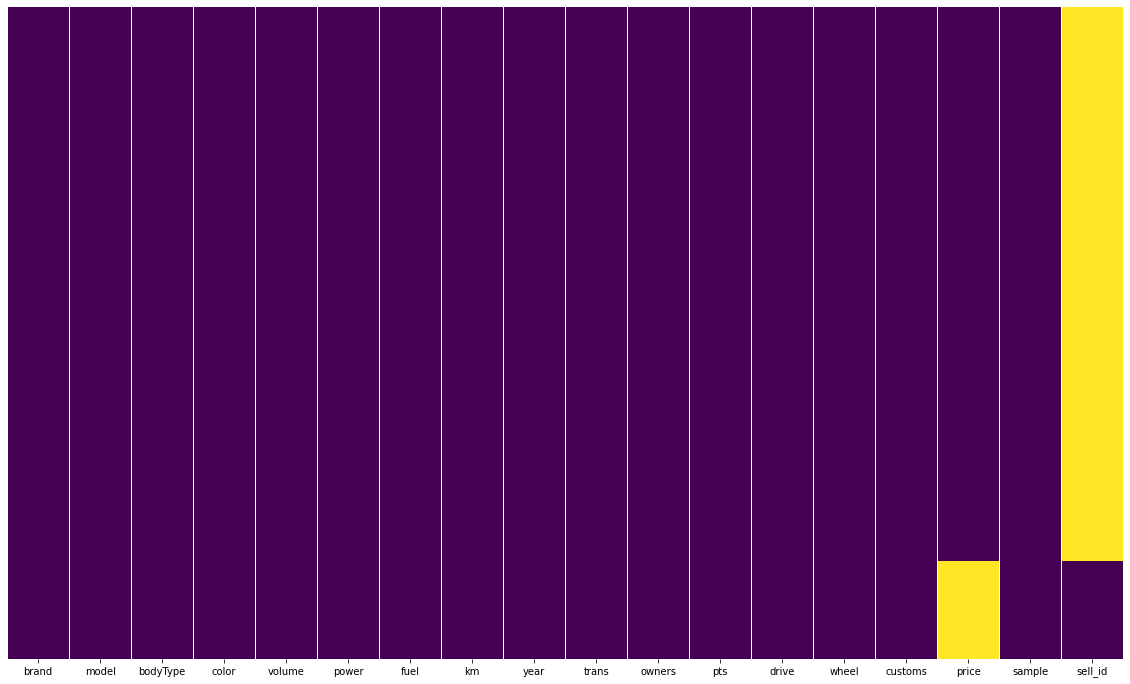

In [33]:
# We look at the gaps with the help of visualization
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(work.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [34]:
# Replacing omissions for the "volume" attribute"
work.volume.fillna(work.volume.mean(),inplace=True)

In [35]:
# Clearing RAM:
del train,test,train_1,train_2


## Column description:

* brand - car brand : mercedes, bmw etc.
* model - car model : elantra, almera etc.
* bodyType - body of the car : coupe, hatchback etc. 
* color - just color
* volume - volume of the car's engine(instead of electrocar)
* power - power in horse powers
* fuel - type of fuel : gas, petrol, diesel ...
* km - distance that car have passed
* year - manufacture year
* trans - transmission type: manual,auto ... 
* owners - how many owners have used the car
* pts - passport of the car
* drive - the car's drive unit : front-wheel, 4X4 ...
* wheel - wheel position : left or right
* customs - did the car passed customs
* price - this is the target variable, cost of the car
* sell_id - unique id, will be used for submission

# **4. Working with features**

### Pts

In [36]:
# There is some abbreviated values:
print(pd.Series(work.pts.unique()).sort_values().to_list())

['Д', 'Дубликат', 'Оригинал']


In [37]:
# Here we will unify them:
work.pts = work.pts.replace('Д','Дубликат')

### Fuel

In [38]:
# Comparing lists of needed fuel with existing:
print(work.fuel.unique())
print(fuel_list)

['бензин' 'дизель' 'гибрид' 'газ' 'электро'
 'бензин, газобаллонное оборудование' 'гибрид, газобаллонное оборудование'
 'газ, газобаллонное оборудование' 'дизель, газобаллонное оборудование']
['бензин', 'дизель', 'гибрид', 'электро', 'газ']


In [39]:
# Inplacing values:
work.fuel = work.fuel.replace('газ, газобаллонное оборудование','газ')
work.fuel = work.fuel.replace('бензин, газобаллонное оборудование','бензин')
work.fuel = work.fuel.replace('гибрид, газобаллонное оборудование','гибрид')
work.fuel = work.fuel.replace('дизель, газобаллонное оборудование','дизель')

### BodyType

In [40]:
work.bodyType = work.bodyType.replace('универсал 3 дв.','универсал')
work.bodyType = work.bodyType.replace('универсал 5 дв.','универсал')

### Model

In [41]:
# Unifying values:
num_list = ['0','1','2','3','4','5','6','7','8','9']
work['model'] = work['model'].apply(lambda x: x[0] if x[0] in num_list else x)
work.model = work.model.apply(lambda x:x.replace('-КЛАСС','_KLASSE'))

In [42]:
# Comparing numbers of unique models in train and test:
print(len(work.model[work['sample'] == 1].unique()))
print(len(work.model[work['sample'] == 0].unique()))

662
517


In [43]:
# Unifying models:
model_list = work.model[work['sample'] ==0 ].unique().tolist()
work.model = work.model.apply(lambda x:'other' if x not in model_list else x)
model_list = work.model[work['sample'] ==1 ].unique().tolist()
work.model = work.model.apply(lambda x:'other' if x not in model_list else x)
print(len(work.model[work['sample'] == 1].unique()))
print(len(work.model[work['sample'] == 0].unique()))

374
374


### New features

In [44]:
''' Creating a new feature "age" - the age of the car,
based on the feature "year" - the year of manufacture'''
work['age']=2021-work.year

In [45]:
# This feature will show us the Exploitation degree of each car:
work['usage'] =work.age/work.km*10000


In [46]:
# Creating a new feature "brand_freq" - the frequency of brand in the dataframe:
freq = work["brand"].value_counts(normalize = True)
work["brand_freq"] = work["brand"].map(freq)
work[["brand", "brand_freq"]].sample(3)

,brand,brand_freq
175187,BMW,0.110640
108386,NISSAN,0.141723
34972,TOYOTA,0.171531


In [47]:
# Creating a new attribute "model_freq" - the frequency of model in the dataframe
freq_m = work["model"].value_counts(normalize = True)
work["model_freq"] = work["model"].map(freq_m)
work[["model", "model_freq"]].sample(3)

,model,model_freq
147102,3,0.021022
40902,POLO,0.027363
165207,CARINA,0.003707


### Numeric features

In [48]:
# Defining attributes for a numeric data group
num_cols=['volume','power','km','year','owners','age','brand_freq','model_freq','usage']

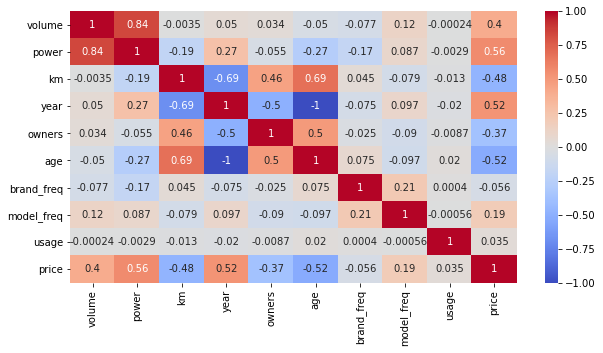

In [49]:
# Constructing the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(work[num_cols+['price']].corr(), annot=True,cmap='coolwarm')

The year and the age features are fully correlated, this allows us to exclude the year column. 
As we will see later the age value is the most significant among the numeric values.

In [50]:
work.drop('year',axis=1,inplace = True)

In [51]:
# Defining attributes for numeric data group
num_cols=['volume','power','km','age','brand_freq','model_freq','usage']

### Categorical features

In [52]:
#Defining attributes for categorial data group 
bin_cols = ['pts','wheel','customs']
cat_cols = ['brand','bodyType','color','fuel','drive','trans','owners','model']

# **5. Exploratory Data Analysis**

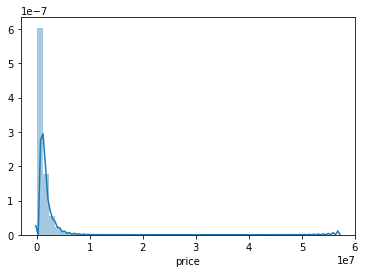

In [53]:
# Building graphic of the target variable distirbution:
sns.distplot(work.price)#

We can see high distribution bias, so, later, it needs to be normalized.  

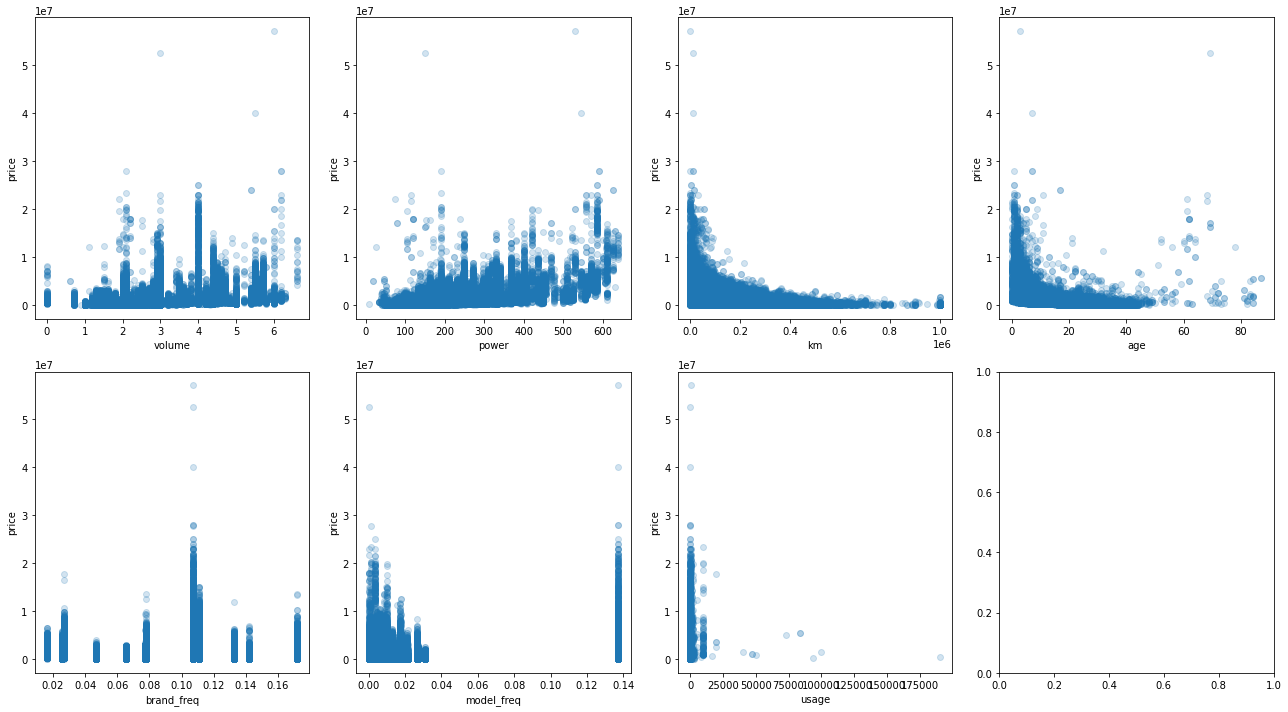

In [54]:
# Building graphs of target variable dependency from numeric features:
y = work['price']
X = work.drop(columns=['price','sample'])
fig, axs = plt.subplots(figsize=(18, 10), ncols=4,nrows =2)
for i, feature in enumerate(num_cols[0:4]):
    axs[0][i].scatter(X[feature], y, alpha=0.2)
    axs[0][i].set_xlabel(feature)
    axs[0][i].set_ylabel("price")
for i, feature in enumerate(num_cols[4:len(num_cols)]):   
    axs[1][i].scatter(X[feature], y, alpha=0.2)
    axs[1][i].set_xlabel(feature)
    axs[1][i].set_ylabel("price") 


plt.tight_layout()

 * Price is directry dependent from volume and power
 * Price is inversaly dependent from ditance, age and usage
 * Also we see inversaly dependentce from model_freq with ouliers. 
 This is models with numeric names (table was above)

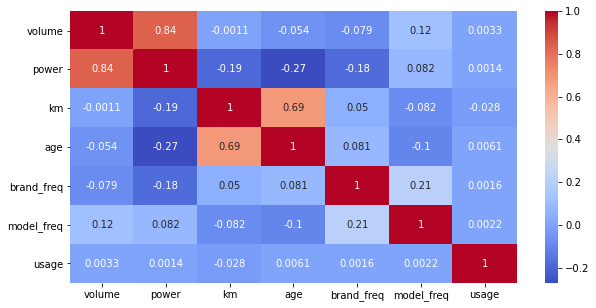

In [55]:
"""Let's  draw the correlation plot for train data
(work['sample'] == 1) again:"""

correlation = work[work['sample'] == 1][num_cols].corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation, annot=True, cmap='coolwarm')


As we can see, there is only one high correlation - between power and volume, but, for now, this is not the reason to drop someone of them down. 

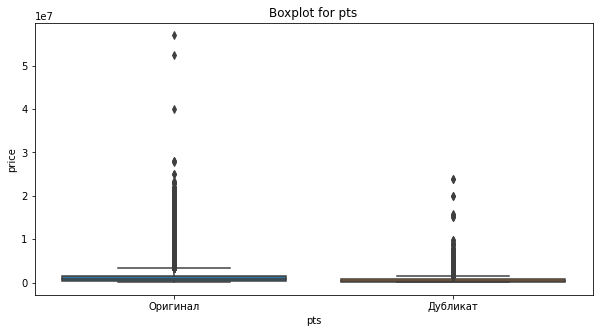

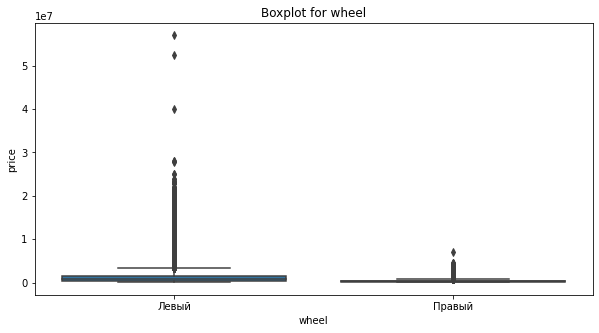

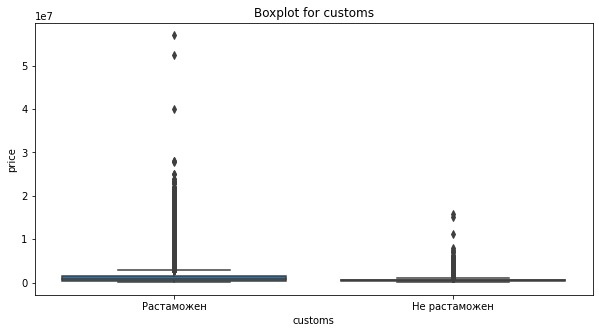

In [56]:
# Drawing boxplots for bin values:

for i in bin_cols:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(x=work[work['sample'] == 1][i],
                y=work[work['sample'] == 1].price)
                
    ax.set_title('Boxplot for ' + i)
    plt.show()

Car with left wheel, original pts, which has passed customs will cost more than others 

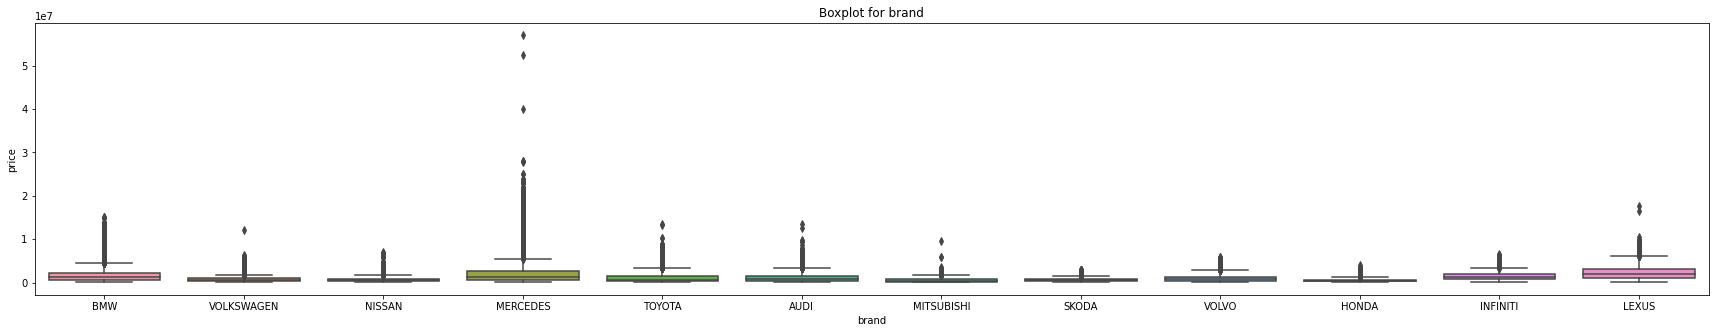

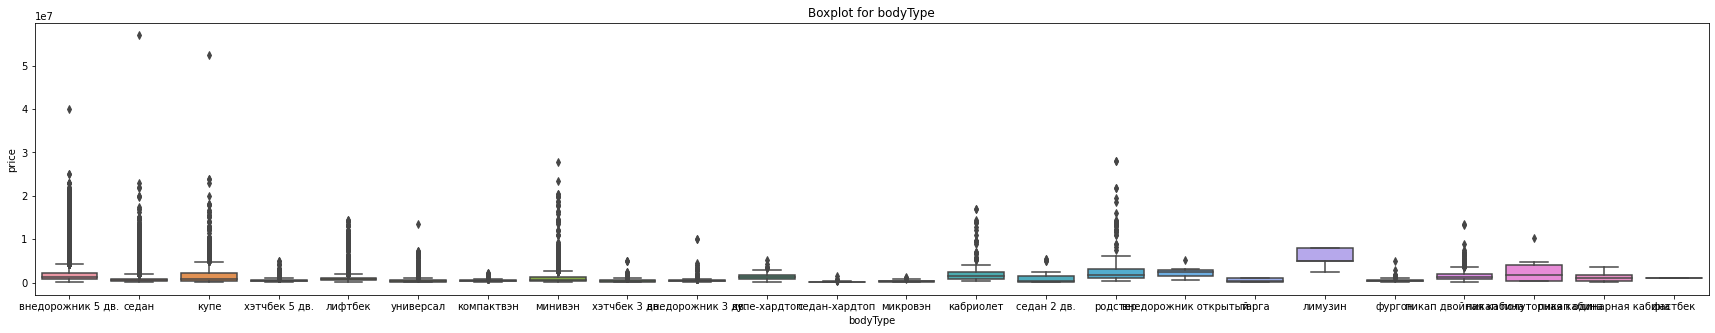

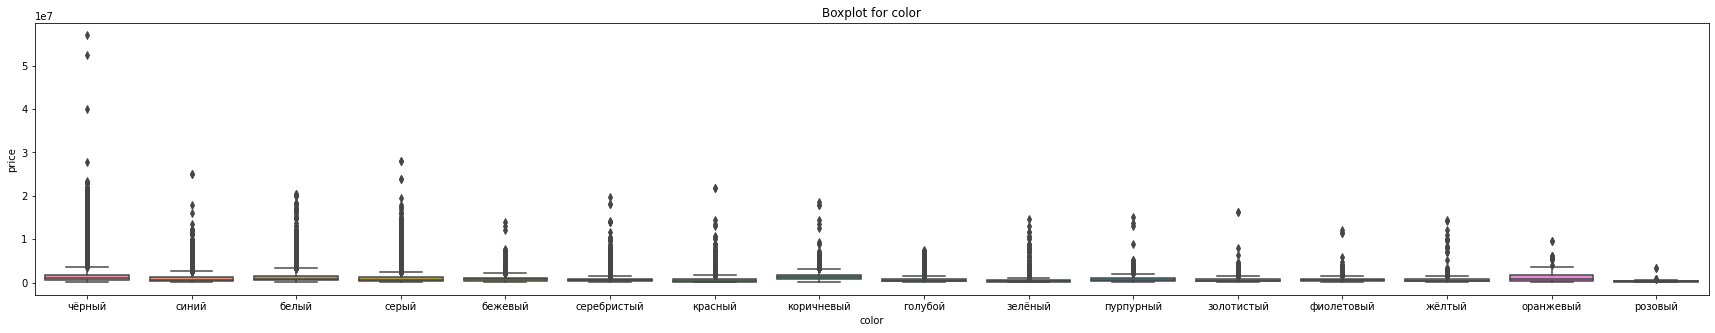

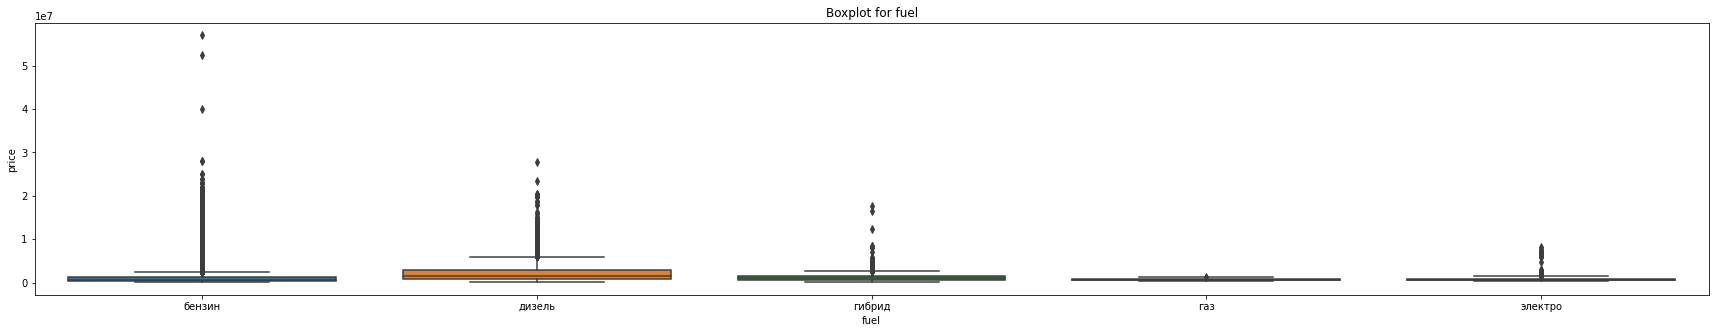

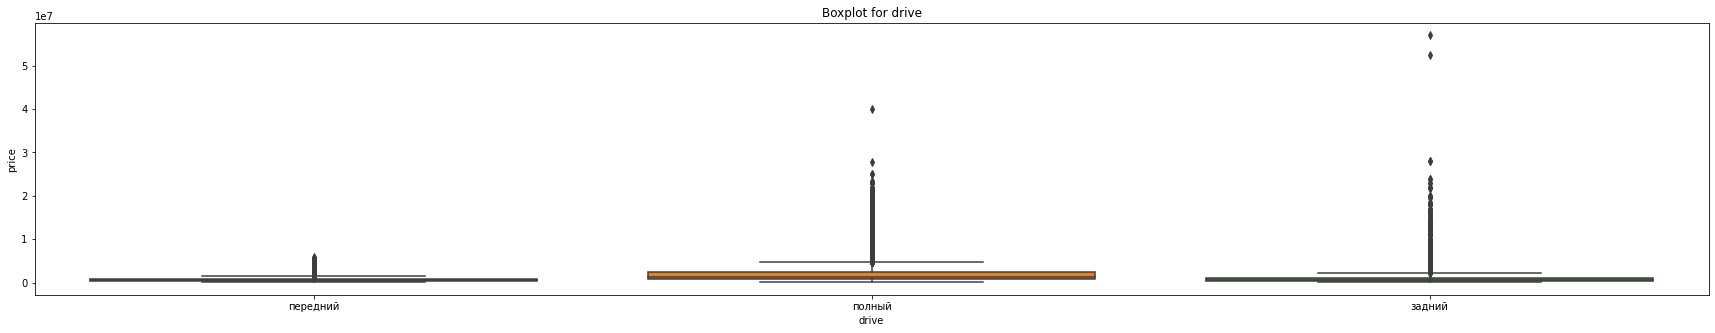

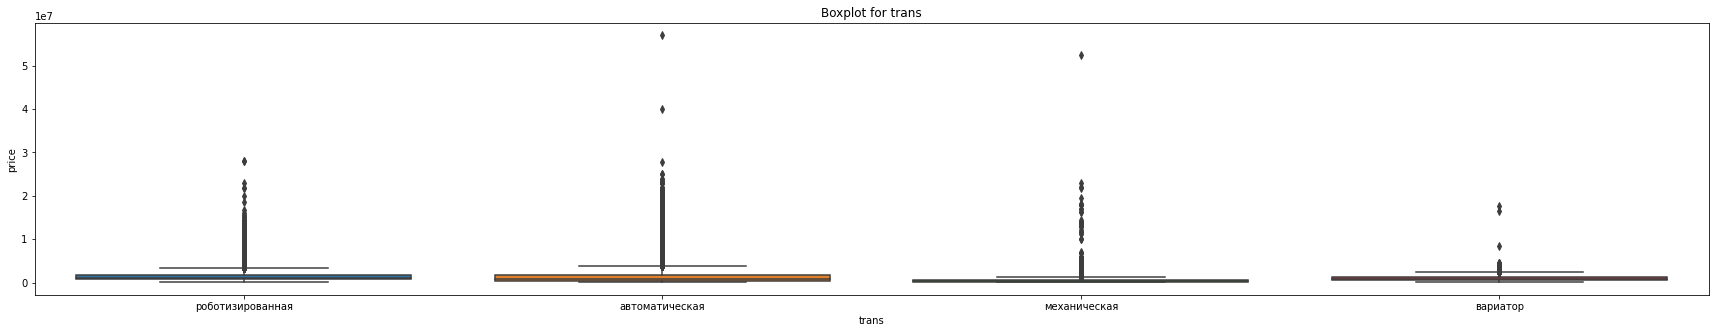

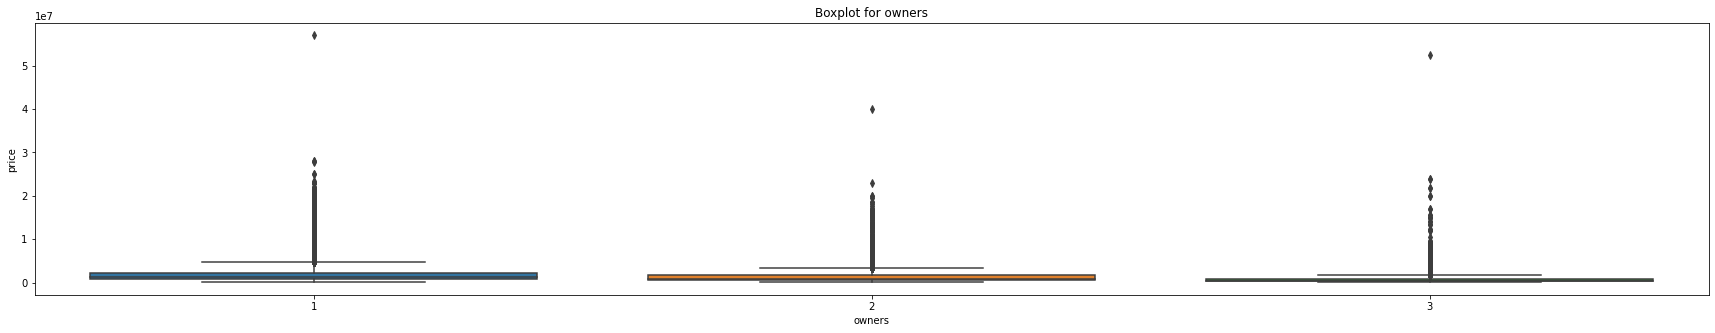

In [57]:
# Drawing boxplots for cat values:

for i in (cat_cols[0:-1]):
    fig, ax = plt.subplots(figsize=(30, 5))
    sns.boxplot(x=work[work['sample'] == 1][i],
                y=work[work['sample'] == 1].price)
                
    ax.set_title('Boxplot for ' + i)
    plt.show()

We see that:
* Mercedes and Lexus are the most expensive brands
* Limusine body costs more than other bodytypes
* Diesel motors are more expensive than others
* Full drive is more expensive than others
* Auto and robot transmissions are more expensively
* The more owners had the car, the price will be lower 

Text(0.5, 0, 'F-value')

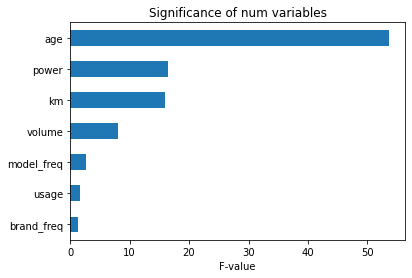

In [58]:
#Significance of num variables
imp_num = Series(f_classif(work[work['sample'] == 1][num_cols],
                           work[work['sample'] == 1]['price'])[0],
                           index = num_cols
                           )
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

In [59]:
#dataframe to draw significance graph for cat and bin features:

work_sign = work 
for column in bin_cols:
     work_sign[column] = LabelEncoder().fit_transform(work_sign[column])
for column in cat_cols:
     work_sign[column] = LabelEncoder().fit_transform(work_sign[column])

Text(0.5, 1.0, 'Significance of cat variables')

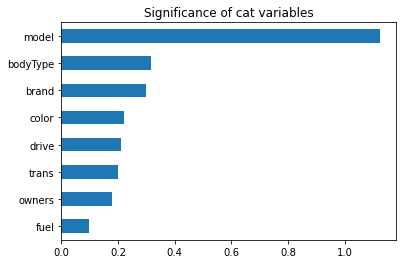

In [60]:
# Significance of cat variables
imp_cat = Series(mutual_info_classif(work_sign[work_sign['sample'] == 1][cat_cols],
                                     work_sign[work_sign['sample'] == 1]['price'],
                                     discrete_features =True),
                                     index = cat_cols
                                     )
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Significance of cat variables')


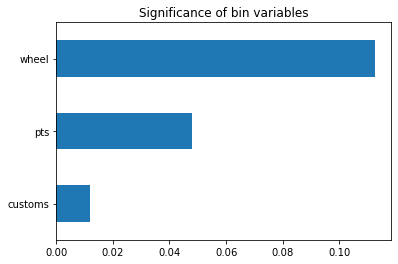

In [61]:
# Significance of bin variables

imp_bin = Series(mutual_info_classif(work_sign[work_sign['sample'] == 1][bin_cols],
                                     work_sign[work_sign['sample'] == 1]['price'],
                                     discrete_features =True),
                                     index = bin_cols
                                     )
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')
del work_sign

# **6. Data preprocessing**

In [62]:
#Transforming binary variables:

for column in bin_cols:
     work[column] = LabelEncoder().fit_transform(work[column])
#Model can read only numbers,so now our bins is zero an one:
work.sample(5)

,brand,model,bodyType,color,volume,power,fuel,km,trans,owners,...,drive,wheel,customs,price,sample,sell_id,age,usage,brand_freq,model_freq
150687,9,373,1,15,3.0,173,3,149000,0,2,...,2,0,1,1950000.0,1,NaN,9,0.604027,0.171531,0.137051
19117,9,373,1,11,4.7,235,0,329018,0,2,...,2,0,1,1249000.0,1,NaN,15,0.455902,0.171531,0.137051
164226,0,316,5,13,2.0,230,0,63000,3,2,...,2,0,1,2800000.0,1,NaN,5,0.793651,0.078026,0.000751
51973,10,330,15,13,1.8,75,0,181805,0,2,...,1,0,1,100000.0,1,NaN,27,1.485108,0.132533,0.000566
79085,10,218,15,1,1.6,110,0,100000,0,0,...,1,0,1,750000.0,1,NaN,5,0.500000,0.132533,0.027363


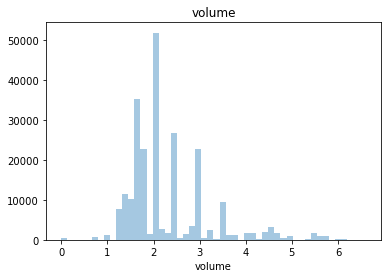

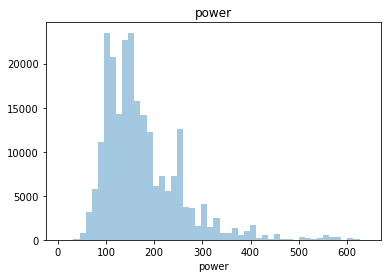

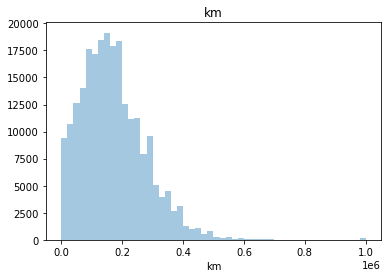

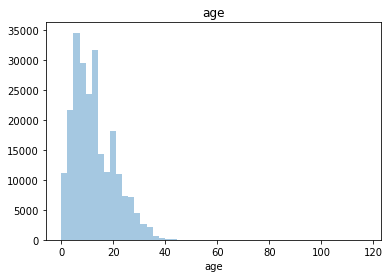

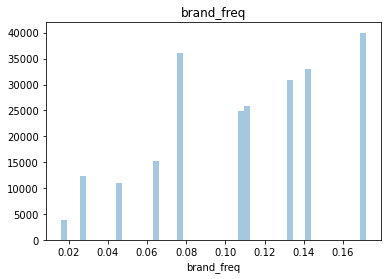

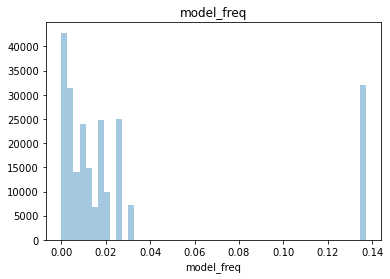

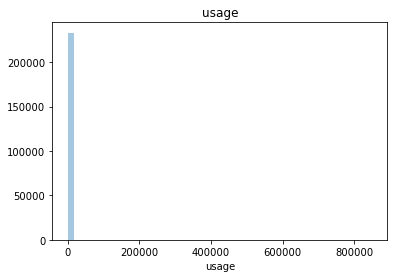

In [63]:
#Now we need to draw some graphs, to check the distribution:
for i in num_cols:
    plt.figure()
    sns.distplot(work[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

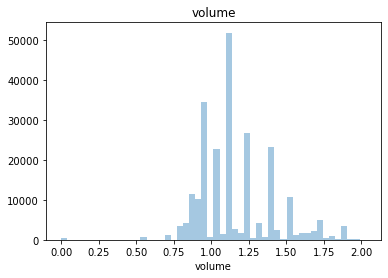

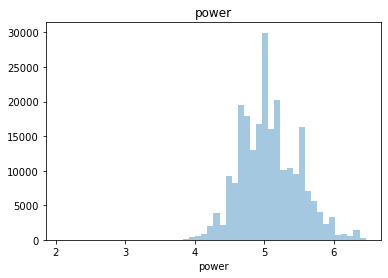

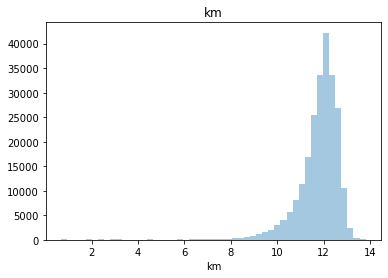

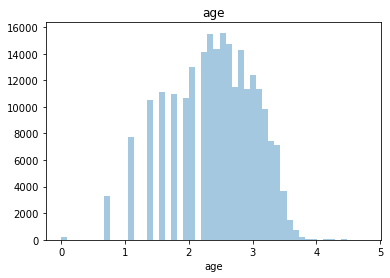

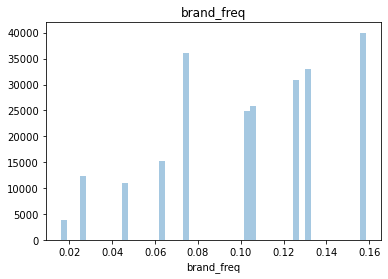

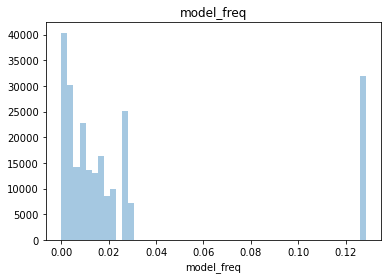

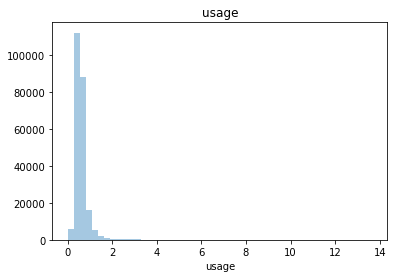

In [64]:
'''As we can see numeric columns need to be normalized.
   Let's logarithm them:'''

for i in num_cols:
    work[i] = np.log(work[i] + 1)
    
# And check for the distribution:
for i in num_cols:
    plt.figure()
    sns.distplot(work[i], kde = False, rug=False)
    plt.title(i)
    plt.show()

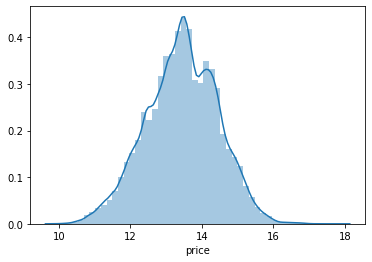

In [65]:
#Normalazing price
work.price = np.log(work.price + 1)
sns.distplot(work.price)

Now we see a good normalization

In [66]:
#Transforming categorical variables:

x_cat_train = OneHotEncoder(sparse = False).fit_transform(work[work['sample'] == 1][cat_cols].values)
x_cat_val = OneHotEncoder(sparse = False).fit_transform(work[work['sample'] == 0][cat_cols].values)

print(x_cat_train.shape)
print(x_cat_val.shape)

(198403, 441)
(34686, 441)


In [67]:
poly = PolynomialFeatures(2)#Set the power 
# And transform numeric variables:
x_train = poly.fit_transform(work[work['sample'] == 1][num_cols].values)
x_val = poly.fit_transform(work[work['sample'] == 0][num_cols].values)
# Use Scaler:
x_num_train = StandardScaler().fit_transform(x_train)
x_num_val = StandardScaler().fit_transform(x_val)

In [68]:
# Merge our prepared data, and don't forget to split the test data:

X = np.hstack([x_num_train,
               work[work['sample'] == 1][bin_cols+['owners']].values,
               x_cat_train]
              )
Y = work[work['sample'] == 1]['price'].values

id_test = work[work['sample'] == 0].sell_id
test = np.hstack([x_num_val,
                  work[work['sample'] == 0][bin_cols+['owners']].values,
                  x_cat_val]                
                )
print(X.shape)
print(test.shape)

(198403, 481)
(34686, 481)


In [69]:
# Split  data to train our model:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
test_size=0.3, random_state=42, shuffle = True)

# Models

## **1. Naive model**

In [70]:
# Naive model as a start point:
X_naive = work.query('sample == 1').drop(['sample', 'price'], axis=1)
y_naive = work.query('sample == 1')['price'] 
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_naive,y_naive,
    test_size=0.2, shuffle=True, random_state=RANDOM_SEED)
tmp_train = Xn_train.copy()
tmp_train['price'] = yn_train
predict = Xn_test['power'].map(tmp_train.groupby('power')['price'].median())
print("MAPE: ",mape(yn_test, predict.values)*100)

MAPE:  3.6244255372084457


## **2. Bagging**

In [71]:

# Let's try on tree at first:
tree = DecisionTreeRegressor(max_features=int(X_train.shape[1]/3), max_depth=80)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print("MAPE: ",mape(y_test, y_pred)*100)


MAPE:  1.0447221626355163


In [72]:

# And now we'll create ensemle with BaggingRegressor:
btr = BaggingRegressor(tree,n_estimators=3,
                       random_state=RANDOM_SEED,
                       n_jobs=6)
btr.fit(X_train, y_train)
y_pred = btr.predict(X_test)
print("MAPE: ",mape(y_test, y_pred)*100)


MAPE:  1.0387322815239823


## **3. RandomForest**

In [73]:

# Default parameters:
rfr = RandomForestRegressor(random_state=42)
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
print("MAPE: ",mape(y_test, y_pred)*100)


MAPE:  0.8948559431808192


In [74]:
'''Searching for best parameters:'''
'''
grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 4)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rfr = RandomForestRegressor(random_state = RANDOM_SEED)
rfr_search = RandomizedSearchCV(estimator = rfr, 
                                param_distributions = grid,
                                n_iter = 100, cv = 3, 
                                verbose=10, 
                                random_state=RANDOM_SEED,
                                n_jobs = -1)

rfr_search.fit(X_train, y_train)
rfr_search.best_params_
'''


"\ngrid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 500, num = 4)],\n               'max_features': ['auto', 'sqrt'],\n               'max_depth': [int(x) for x in np.linspace(5, 15, num = 6)] + [None],\n               'min_samples_split': [2, 5, 10],\n               'min_samples_leaf': [1, 2, 4],\n               'bootstrap': [True, False]}\n\nrfr = RandomForestRegressor(random_state = RANDOM_SEED)\nrfr_search = RandomizedSearchCV(estimator = rfr, \n                                param_distributions = grid,\n                                n_iter = 100, cv = 3, \n                                verbose=10, \n                                random_state=RANDOM_SEED,\n                                n_jobs = -1)\n\nrfr_search.fit(X_train, y_train)\nrfr_search.best_params_\n"

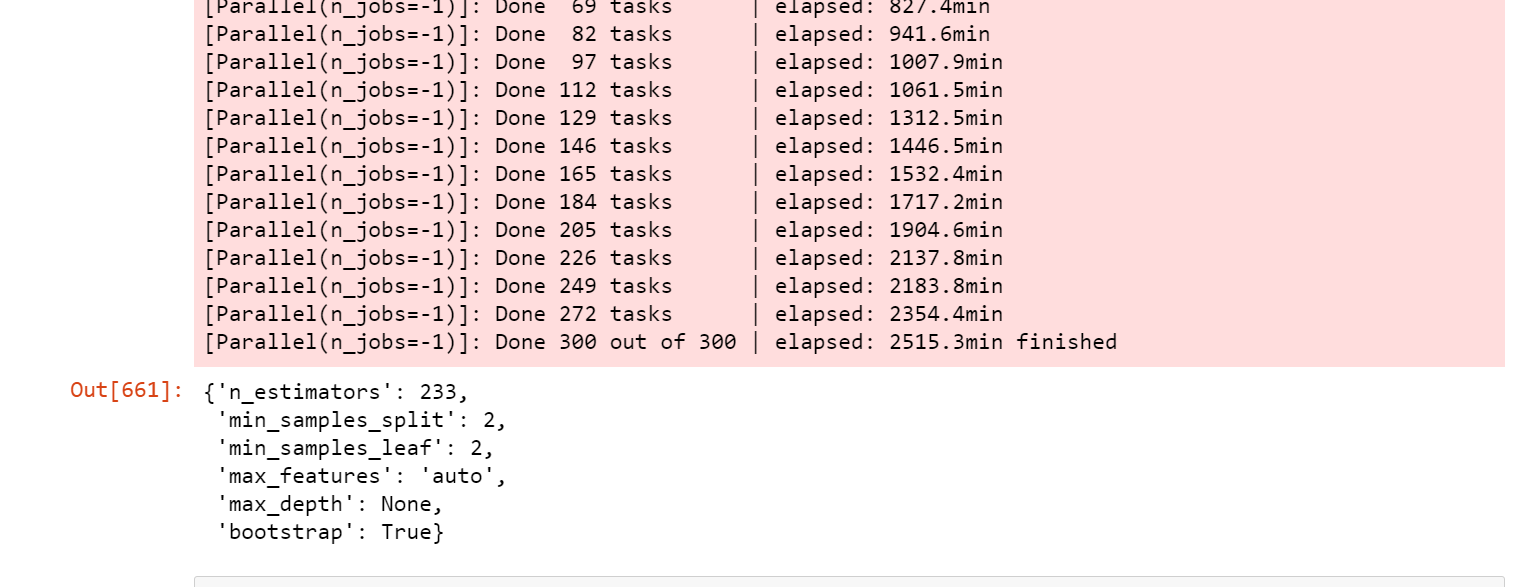

In [75]:
# Using best parameters:
rfr = RandomForestRegressor(n_estimators = 233,
                            min_samples_split = 2,
                            min_samples_leaf = 2,
                            max_features = 'auto',
                            max_depth = None,
                            bootstrap = True,
                            random_state = 42, n_jobs=6)
rfr.fit(X_train, y_train)
y_pred= rfr.predict(X_test)
print("MAPE: ",mape(y_test, y_pred)*100)


MAPE:  0.9187966715765196


## **4. GradientBoosting**

In [76]:

# Using GradientBoost with founded hyperparameters:
gbr = GradientBoostingRegressor(max_depth=15,n_estimators=700,
                                learning_rate=0.15,random_state=42) 
                                
gbr.fit(X_train, y_train)
y_pred = gbr.predict(X_test)
print("MAPE: ",mape(y_test, y_pred)*100)


MAPE:  0.8235510665409222


## **5. Bagging over GradientBoosting**

In [77]:
bag_gbr = BaggingRegressor(gbr,
                         n_estimators=3,
                         random_state=RANDOM_SEED,
                         n_jobs=6)
bag_gbr.fit(X_train, y_train)
y_pred = bag_gbr.predict(X_test)
print("MAPE: ",mape(y_test, y_pred)*100)

MAPE:  0.9061152057155183


## **6. XgBoost**

In [96]:
# Trying XgBoost
xgb = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.5,
                          learning_rate=0.05, max_depth=12, alpha=1,
                          n_estimators=1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
print("MAPE: ",mape(y_test, y_pred)*100)

MAPE:  0.9042933429418589


## **7. Catboost**

In [78]:
# Using CatBoostRegressor with founded hyperparameters:
cbr = CatBoostRegressor(iterations = 15000,
                          learning_rate = 0.15,
                          depth = 7,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE']
                         )
cbr.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=True
         )
y_pred = cbr.predict(X_test)
mape(y_test,y_pred)*100


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0524711	test: 0.0526311	best: 0.0526311 (0)	total: 116ms	remaining: 29m 3s
500:	learn: 0.0102221	test: 0.0106992	best: 0.0106992 (500)	total: 21.2s	remaining: 10m 13s
1000:	learn: 0.0094418	test: 0.0102807	best: 0.0102807 (1000)	total: 42.1s	remaining: 9m 48s
1500:	learn: 0.0089290	test: 0.0100554	best: 0.0100554 (1500)	total: 1m 5s	remaining: 9m 49s
2000:	learn: 0.0085347	test: 0.0099166	best: 0.0099166 (2000)	total: 1m 28s	remaining: 9m 35s
2500:	learn: 0.0082045	test: 0.0098024	best: 0.0098024 (2500)	total: 1m 52s	remaining: 9m 21s
3000:	learn: 0.0079193	test: 0.0097249	best: 0.0097249 (3000)	total: 2m 16s	remaining: 9m 5s
3500:	learn: 0.0076659	test: 0.0096511	best: 0.0096510 (3499)	total: 2m 40s	remaining: 8m 47s
4000:	learn: 0.0074240	test: 0.0095867	best: 0.0095866 (3999)	total: 3m 5s	remaining: 8m 30s
4500:	learn: 0.0072081	test: 0.0095289	best: 0.0095289 (4500)	total: 3m 32s	remaining: 8m 15s
5000:	learn: 0.0070052	test: 0.0094798	best: 0.0094797 (4999)	total: 3m 5

0.8994270030629364

## **8. Stacking**

In [88]:
#Let's set the models for ensemble
bag_gbr =BaggingRegressor(
            GradientBoostingRegressor(random_state=RANDOM_SEED,
                                      n_estimators=700,
                                      min_samples_split=5,
                                      min_samples_leaf=4,
                                      max_features='sqrt',
                                      max_depth=9),
            n_estimators=3,
            n_jobs=-1,
            random_state=RANDOM_SEED)

xgb = xgb.XGBRegressor(objective='reg:squarederror',
                       colsample_bytree=0.5,
                       learning_rate=0.05,
                       max_depth=12,
                       alpha=1,
                       n_estimators=1000)

cbr = CatBoostRegressor(iterations = 5000,
                        random_seed = RANDOM_SEED,
                        eval_metric='MAPE',
                        custom_metric=['R2', 'MAE'],
                        silent=True,
                        learning_rate=0.15,
                        depth=12,
                        l2_leaf_reg=8,
                        random_strength=0.3)

#Now stack them in ensemble
ensemble = StackingRegressor(estimators=[('bag_gbr',bag_gbr),
                                         ('xgb',xgb)],
                             final_estimator = cbr)
ensemble.fit(X_train, y_train)
y_pred = ensemble.predict(X_test)
print("MAPE: ",mape(y_test, y_pred)*100)

MAPE:  0.9408361391169459


## ** 9. Choosing model**
Best result on leaderboard showed us CatboostRegression. Let's try to tune it up, maybe we'll take a better result...

In [105]:
# Using CatBoostRegressor with tuned hyperparameters:
cbr = CatBoostRegressor(iterations = 8800,
                        learning_rate = 0.15,
                        depth = 12,
                        random_seed = RANDOM_SEED,
                        eval_metric='MAPE',
                        custom_metric=['RMSE'],
                        rsm = 0.1
                         )
cbr.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=500,
         use_best_model=True,
         plot=False
         )
y_pred = cbr.predict(X_test)
mape(y_test,y_pred)*100

0:	learn: 0.0525184	test: 0.0526764	best: 0.0526764 (0)	total: 232ms	remaining: 33m 58s
500:	learn: 0.0084519	test: 0.0100401	best: 0.0100401 (500)	total: 1m 58s	remaining: 32m 45s
1000:	learn: 0.0070701	test: 0.0095812	best: 0.0095812 (1000)	total: 4m 3s	remaining: 31m 33s
1500:	learn: 0.0060904	test: 0.0093138	best: 0.0093138 (1500)	total: 6m 10s	remaining: 29m 59s
2000:	learn: 0.0053633	test: 0.0091373	best: 0.0091373 (2000)	total: 8m 18s	remaining: 28m 14s
2500:	learn: 0.0047901	test: 0.0090070	best: 0.0090070 (2500)	total: 10m 25s	remaining: 26m 14s
3000:	learn: 0.0043047	test: 0.0088968	best: 0.0088968 (3000)	total: 12m 32s	remaining: 24m 14s
3500:	learn: 0.0038977	test: 0.0088111	best: 0.0088111 (3500)	total: 14m 39s	remaining: 22m 11s
4000:	learn: 0.0035515	test: 0.0087341	best: 0.0087341 (4000)	total: 16m 47s	remaining: 20m 8s
4500:	learn: 0.0032755	test: 0.0086745	best: 0.0086745 (4500)	total: 18m 48s	remaining: 17m 57s
5000:	learn: 0.0030247	test: 0.0086222	best: 0.0086222 (

0.8373087089953611

# Submission

In [106]:
'''Let's check for the car price changes in Russia:'''
url = 'https://www.autonews.ru/news/600545f29a79471abd5bf1ae'  
changes = pd.read_html(url)[0][1:]# Check the price changes dynamics
changes.columns = changes.iloc[0].to_list()
changes = changes.reset_index(drop = True)[1:].dropna()
changes["Разница"] = changes["Разница"].apply(lambda x:x.replace(' ',''))
changes["Цена в декабре'20"] = changes["Цена в декабре'20"].apply(lambda x:x.replace(' ',''))
changes["Цена в декабре'20"] =pd.to_numeric(changes["Цена в декабре'20"])
changes["Разница"] = pd.to_numeric(changes["Разница"])
changes['%'] = changes['Разница']/changes["Цена в декабре'20"]*100
display(changes)
print('Average price change:',round(changes['%'].mean(),1),'%')


,Модель,Цена в декабре'20,Цена в январе’21,Разница,%
1,Lada Vesta,676900,703 900,27000,3.988772
2,Lada Vesta с вариатором,808000,828 900,20900,2.586634
3,Lada Granta,488900,499 900,11000,2.249949
4,UAZ Patriot,889000,969 000,80000,8.998875
5,Toyota Corolla,1379000,1 411 000,32000,2.320522
6,Skoda Rapid,847000,872 000,25000,2.951594
7,Skoda Karoq 1.4 TSI,1521000,1 552 000,31000,2.038133
8,Audi Q3 Sportback,2615000,2 675 000,60000,2.294455


Average price change: 3.4 %


In [107]:
'''As we can see the difference is about 3%,
let's correction coefficient:'''
coef = 0.97
sub = cbr.predict(test)
sub = np.exp(sub)-1
sub = sub*coef


In [108]:
my_submission = pd.DataFrame({'sell_id': id_test, 
                            'price': sub})
my_submission.sell_id = my_submission.sell_id.apply(lambda x: int(x))
my_submission.price =  my_submission.price.apply(lambda x: int(x))
my_submission.to_csv('submission.csv', index=False)
my_submission.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34686 entries, 198403 to 233088
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   sell_id  34686 non-null  int64
 1   price    34686 non-null  int64
dtypes: int64(2)
memory usage: 813.0 KB
